<a href="https://colab.research.google.com/github/jnrhrry/TimeSeriesLSTM/blob/main/Time_Series_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Necessary Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM

Import Dataset

In [ ]:
df = pd.read_csv('heart_rate_throughout_a_day.csv')
df

,time,value
0,00:00:01,61
1,00:00:06,63
2,00:00:16,62
3,00:00:26,63
4,00:00:41,63
...,...,...
10895,23:58:25,83
10896,23:58:30,83
10897,23:58:35,81
10898,23:58:40,78


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    10900 non-null  object
 1   value   10900 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 170.4+ KB


Converting to float32

In [ ]:
df['value'] = df['value'].astype(np.float32)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    10900 non-null  object 
 1   value   10900 non-null  float32
dtypes: float32(1), object(1)
memory usage: 127.9+ KB


In [ ]:
df.isnull().sum()

time     0
value    0
dtype: int64

In [ ]:
time = df['time'].values
value = df['value'].values

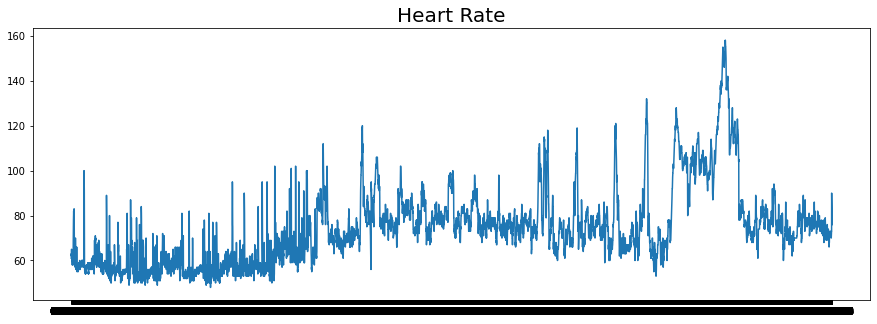

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(time, value)
plt.title('Heart Rate', fontsize=20);

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(value, window_size = 60, batch_size = 200, shuffle_buffer= 1000)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(LSTM(60)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
class realCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<10):
      print("\nMAE model less than 10% data scale.")
      self.model.stop_training = True
      callbacks = realCallback()

In [55]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-05, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500, callbacks=[callbacks])

Epoch 1/500
55/55 [==============================] - 23s 419ms/step - loss: 74.3766 - mae: 74.8766
Epoch 2/500
55/55 [==============================] - 23s 418ms/step - loss: 74.2913 - mae: 74.7913
Epoch 3/500
55/55 [==============================] - 23s 421ms/step - loss: 74.2435 - mae: 74.7435
Epoch 4/500
55/55 [==============================] - 23s 420ms/step - loss: 74.2112 - mae: 74.7112
Epoch 5/500
55/55 [==============================] - 23s 419ms/step - loss: 74.1881 - mae: 74.6881
Epoch 6/500
55/55 [==============================] - 23s 421ms/step - loss: 74.1712 - mae: 74.6712
Epoch 7/500
55/55 [==============================] - 23s 422ms/step - loss: 74.1553 - mae: 74.6553
Epoch 8/500
55/55 [==============================] - 23s 420ms/step - loss: 74.1428 - mae: 74.6428
Epoch 9/500
55/55 [==============================] - 23s 422ms/step - loss: 74.1304 - mae: 74.6304
Epoch 10/500
55/55 [==============================] - 23s 424ms/step - loss: 74.1192 - mae: 74.6192
Epoch 11/

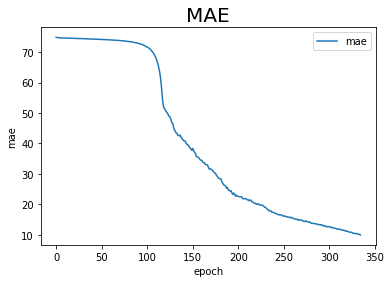

In [56]:
plt.plot(history.history['mae'])
plt.title('MAE', fontsize = 20)
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend(['mae'], loc= 'upper right')
plt.show()